In [151]:
import numpy as np; import copy
def input_set(sys_no,input_type,input_len,scale): 
    if(0==input_type): 
        input_raw=2*np.random.random(input_len)-1
    elif(1==input_type): 
        input_raw=np.random.random(input_len)
    elif(2==input_type):
        input_raw=0.325*np.random.standard_normal(size=input_len);
    elif(3==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=(-0.1)*white_noise[0]
        input_raw[1]=0.04*input_raw[0]-0.1*white_noise[1]-0.01*white_noise[0]
        input_raw[2]=0.04*input_raw[1]-0.034*input_raw[0]-0.1*white_noise[2]-0.01*white_noise[1]-0.137*white_noise[0]
        input_raw[3]=0.04*input_raw[2]-0.034*input_raw[1]+0.0396*input_raw[0]-0.1*white_noise[3]-0.01*white_noise[2] \
                     -0.137*white_noise[1]+0.0353*white_noise[0]
        for t in range(4,input_len):
            input_raw[t]=0.04*input_raw[t-1]-0.034*input_raw[t-2]+0.0396*input_raw[t-3]-0.07656*input_raw[t-4] \
            -0.1*white_noise[t]-0.01*white_noise[t-1]-0.137*white_noise[t-2]+0.0353*white_noise[t-3]+0.06984*white_noise[t-4]
        input_raw=0.6*input_raw
    elif(4==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=white_noise[0]
        for t in range(1,input_len):
            input_raw[t]=0.9*input_raw[t-1]#+0.1*white_noise[t] 
    elif(5==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=white_noise[0]
        input_raw[1]=1.79*input_raw[0]+white_noise[1]
        input_raw[2]=1.79*input_raw[1]-1.85*input_raw[0]+white_noise[2]
        input_raw[3]=1.79*input_raw[2]-1.85*input_raw[1]+1.27*input_raw[0]+white_noise[3]
        for t in range(4,input_len):
            input_raw[t]=1.79*input_raw[t-1]-1.85*input_raw[t-2]+1.27*input_raw[t-3]-0.41*input_raw[t-4] \
            +white_noise[t]
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(0.5-0))/(input_raw_max-input_raw_min)
    if(1==scale):
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(0.8-0))/(input_raw_max-input_raw_min)
    output_raw=(np.zeros(input_len)) 
    if(1==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=(1*output_raw[i-1])/(1+output_raw[i-1]**2)+ 1.0*input_raw[i]**2+ 1.0*input_raw[i-3]**2
    elif(0==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=output_raw[i-1]/(1+output_raw[i-1]**2)+input_raw[i]**3
    elif(2==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=input_raw[i]+1.5*np.exp(-((input_raw[i-1]-1)**2)/0.67)-1.5*np.exp(-((input_raw[i-1]+1)**2)/0.67) 
    snr=30;info_power=((np.linalg.norm(output_raw))**2)/input_len;snr_lin = 10**(snr/10);noise_power = info_power/snr_lin;
    output_noise = output_raw + np.sqrt(noise_power)*np.random.standard_normal(input_len)
    return input_raw,output_raw,output_noise
def PNFIR_model(input_data,desire_data,M_num,p_num,train):
    nonlin_input_len=p_num+1;
    weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
    weight_linear = np.zeros(M_num)
    value_a=0
    #weight_a=np.zeros(1)
    lambda_a=0
    input_module = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len);
    input_module_pd1 = np.zeros_like(input_module)
    external_input = np.zeros(M_num); 
    output_modul = np.zeros(M_num*(len(input_data))).reshape(M_num,len(input_data)); 
    output_nonlin = np.zeros_like(output_modul);
    output_linear = np.zeros_like(input_data)
    output_filter = np.zeros_like(input_data)
    dif_output_modul = np.zeros(M_num); 
    error = np.zeros_like(input_data)
    for i in range(M_num+p_num-1,len(input_data)):
        #for ii in range(M_num-1,-1,-1):   # external_input(r) 
        for ii in range(0,M_num):   # external_input(r) 
            if(ii==(M_num-1)):
                external_input[ii]=output_nonlin[0,i-1]
            else :
                external_input[ii]=output_nonlin[ii+1,i]
            for iii in range(0,p_num):
                input_module[ii,iii]=input_data[i-ii-iii-1] # p input
            input_module[ii,p_num]  = external_input[ii]
            output_modul[ii,i]=np.dot(weight_nonlin[ii,:],input_module[ii,:].T)
            output_nonlin[ii,i]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))   
            #dif_output_modul=input_module[ii,:]*( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
            dif_output_modul[ii]=( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
        #if(0==i%100): 
            #print('output_modul:',output_modul[:,i])
            #print('dif_output_modul:',dif_output_modul)
        output_linear=np.dot(weight_linear,output_nonlin[:,i].T)
        lambda_a=1./(1+np.exp((-1)*(copy.deepcopy(value_a))))
        output_filter[i]=lambda_a*output_linear+(1-lambda_a)*(sum(output_modul[:,i]))     
        error[i]=desire_data[i-1] - output_filter[i]
        gama=train[4]
        for iiii in range(0,M_num):
            input_module_pd1[iiii,:]=input_module[iiii,:]*(lambda_a*dif_output_modul[iiii]*weight_linear[iiii]+1-lambda_a);
            if(0==train[3]):
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]
            else:
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]/(gama+np.linalg.norm(input_module_pd1[iiii,:])**2) 
        if(0==train[3]):
            weight_linear+=train[1]*error[i]*(output_nonlin[:,i]).T
        else:
            weight_linear+=train[1]*error[i]*((output_nonlin[:,i]).T)/(gama+np.linalg.norm(((output_nonlin[:,i]).T))**2)
        value_a+=train[2]*error[i]*(output_linear-(sum(output_modul[:,i])))*lambda_a*(1-lambda_a)
    return output_filter,error,weight_linear,weight_nonlin,value_a
def PNFIR_model_zhao(input_data,desire_data,M_num,p_num,train):
    nonlin_input_len=p_num+1;
    weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
    weight_linear = np.zeros(M_num)
    value_a=0
    lambda_a=0
    input_module = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len);
    input_module_pd1 = np.zeros_like(input_module)
    external_input = np.zeros(M_num); 
    output_modul = np.zeros(M_num*(len(input_data))).reshape(M_num,len(input_data)); 
    output_nonlin = np.zeros_like(output_modul);
    output_linear = np.zeros_like(input_data)
    output_filter = np.zeros_like(input_data)
    error = np.zeros_like(input_data)
    for i in range(M_num+p_num-1,len(input_data)):
        for ii in range(M_num-1,-1,-1):   # external_input(r) 
            if(ii==(M_num-1)):
                external_input[ii]=output_nonlin[0,i-1]
            else :
                external_input[ii]=output_nonlin[ii+1,i]
            for iii in range(0,p_num):
                input_module[ii,iii]=input_data[i-ii-iii-1] # p input
            input_module[ii,p_num]  = external_input[ii]
            output_modul[ii,i]=np.dot(weight_nonlin[ii,:],input_module[ii,:].T)
            output_nonlin[ii,i]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))   
            #dif_output_modul=input_module[ii,:]*( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
            dif_output_modul=( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
        output_linear=np.dot(weight_linear,output_nonlin[:,i].T)
        lambda_a=1./(1+np.exp((-1)*(copy.deepcopy(value_a))))
        output_filter[i]=lambda_a*output_linear+(1-lambda_a)*(sum(output_modul[:,i]))     
        error[i]=desire_data[i-1] - output_filter[i]
        gama=train[4]
        for iiii in range(0,M_num):
            input_module_pd1[iiii,:]=input_module[iiii,:]*(lambda_a*dif_output_modul*weight_linear[iiii]+1-lambda_a);
            if(0==train[3]):
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]
            else:
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]/(gama+np.linalg.norm(input_module_pd1[iiii,:])**2) 
        if(0==train[3]):
            weight_linear+=train[1]*error[i]*(output_nonlin[:,i]).T
        else:
            weight_linear+=train[1]*error[i]*((output_nonlin[:,i]).T)/(gama+np.linalg.norm(((output_nonlin[:,i]).T))**2)
        value_a+=train[2]*error[i]*(output_linear-(sum(output_modul[:,i])))*lambda_a*(1-lambda_a)
    return output_filter,error,weight_linear,weight_nonlin,value_a

apoch: 0 PNFIR -21.547210966865666 dB -21.0857827879786 dB
apoch: 50 PNFIR -23.006227809816163 dB -22.5253855106998 dB
apoch: 100 
 mean_MSE: PNFIR 0.007215849762388321 -21.41712517600949 dB 
 0.008036834331878615 -20.94914983954386 dB


C:\Users\Administrator\AppData\Local\Temp/ipykernel_17684/231873435.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR02),color='green',label="PNFIR02",linewidth=0.6)
C:\Users\Administrator\AppData\Local\Temp/ipykernel_17684/231873435.py:23: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR),color='red',label="PNFIR",linewidth=0.6)


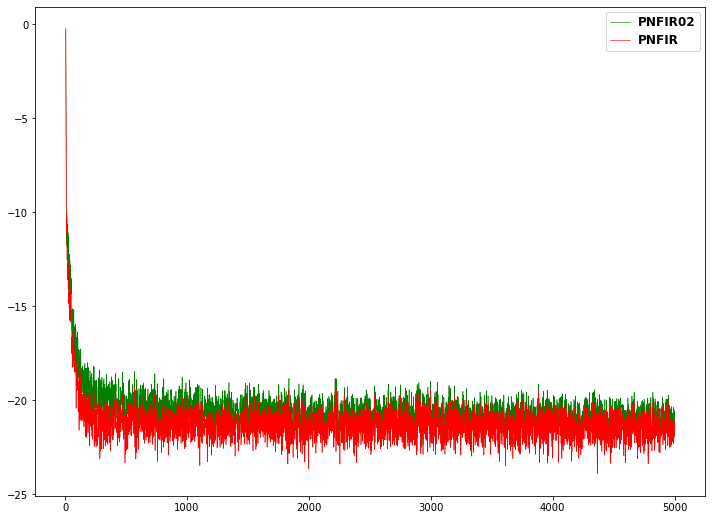

In [152]:
N = 5000; M=5; p=1; apoch=100
train_para=np.array([0.6,0.001,0.6,0,0]) 
error2_sum_PNFIR=np.zeros(N);
error2_sum_PNFIR02=np.zeros(N);
for times in range(0,apoch): 
    x_raw,d_raw,d_noise=input_set(1,1,N,1)    #  random
    #x_raw,d_raw,d_noise=input_set(1,0,N,1)    #  gaussian
    output_filter,error_PNFIR,weight_lin,weght_non,value_a=PNFIR_model(x_raw,d_noise,M,p,train_para)  #PNFIR
    output_filter,error_PNFIR02,weight_lin,weght_non,value_a=PNFIR_model_zhao(x_raw,d_noise,M,p,train_para)  #PNFIR
    error2_sum_PNFIR+=error_PNFIR**2
    error2_sum_PNFIR02+=error_PNFIR02**2
    if(0==times%50):
        print('apoch:',times,'PNFIR',10*np.log10(np.mean(error_PNFIR[-100:]**2)),'dB',\
              10*np.log10(np.mean(error_PNFIR02[-100:]**2)),'dB'
             )
error2_sum_PNFIR/=apoch;
error2_sum_PNFIR02/=apoch;
print('apoch:',apoch,'\n','mean_MSE:','PNFIR',np.mean(error2_sum_PNFIR[-106:-6]),10*np.log10(np.mean(error2_sum_PNFIR[-106:-6])),'dB',\
     '\n',np.mean(error2_sum_PNFIR02[-106:-6]),10*np.log10(np.mean(error2_sum_PNFIR02[-106:-6])),'dB'
     )
import matplotlib.pyplot as plt; plt.figure(figsize=(12, 9)); 
plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR02),color='green',label="PNFIR02",linewidth=0.6)
plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR),color='red',label="PNFIR",linewidth=0.6)
plt.legend(loc=0,numpoints=1);leg=plt.gca().get_legend();ltext=leg.get_texts()
plt.setp(ltext,fontsize=12,fontweight='bold');plt.show()

In [149]:
def PNFIR_GSA_model(input_data,desire_data,train):
    M_num=2;p_num=1;
    nonlin_input_len=p_num+1;
    weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
    weight_linear = np.zeros(M_num)
    value_a=0
    #weight_a=np.zeros(1)
    lambda_a=0
    input_module = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len);
    input_module_pd1 = np.zeros_like(input_module)
    external_input = np.zeros(M_num); 
    output_modul = np.zeros(M_num*(len(input_data))).reshape(M_num,len(input_data)); 
    output_nonlin = np.zeros_like(output_modul);
    output_linear = np.zeros_like(input_data)
    output_filter = np.zeros_like(input_data)
    dif_output_modul = np.zeros(M_num); 
    error = np.zeros_like(input_data)
    for i in range(4+p_num-1,len(input_data)):
        #for ii in range(M_num-1,-1,-1):   # external_input(r) 
        for ii in range(0,M_num):   # external_input(r) 
            if(ii==(M_num-1)):
                external_input[ii]=output_nonlin[0,i-1]
            else :
                external_input[ii]=output_nonlin[ii+1,i]
            if(0==ii):
                input_module[ii,0]=input_data[i]
            elif(1==ii):
                input_module[ii,0]=input_data[i-3] 
                #input_module[ii,1]=0
#             for iii in range(0,p_num):
#                 input_module[ii,iii]=input_data[i-ii-iii-1] # p input
            input_module[ii,p_num]  = external_input[ii]
            output_modul[ii,i]=np.dot(weight_nonlin[ii,:],input_module[ii,:].T)
            output_nonlin[ii,i]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))   
            dif_output_modul[ii]=( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
        output_linear=np.dot(weight_linear,output_nonlin[:,i].T)
        lambda_a=1./(1+np.exp((-1)*(copy.deepcopy(value_a))))
        output_filter[i]=lambda_a*output_linear+(1-lambda_a)*(sum(output_modul[:,i]))     
        error[i]=desire_data[i] - output_filter[i]
        gama=train[4]
        for iiii in range(0,M_num):
            input_module_pd1[iiii,:]=input_module[iiii,:]*(lambda_a*dif_output_modul[iiii]*weight_linear[iiii]+1-lambda_a);
            if(0==train[3]):
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]
            else:
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]/(gama+np.linalg.norm(input_module_pd1[iiii,:])**2) 
        if(0==train[3]):
            weight_linear+=train[1]*error[i]*(output_nonlin[:,i]).T
        else:
            weight_linear+=train[1]*error[i]*((output_nonlin[:,i]).T)/(gama+np.linalg.norm(((output_nonlin[:,i]).T))**2)
        value_a+=train[2]*error[i]*(output_linear-(sum(output_modul[:,i])))*lambda_a*(1-lambda_a)
    return output_filter,error,weight_linear,weight_nonlin,value_a
N = 5000;  apoch=100
train_para=np.array([0.6,0.001,0.6,0,1e-4]) 
error2_sum_GSA=np.zeros(N);
for times in range(0,apoch):
    x_raw,d_raw,d_noise=input_set(1,1,N,1)  # Random Sequence
    output_filter,error_GSA,weight_lin,weght_non,value_a=PNFIR_GSA_model(x_raw,d_noise,train_para)  #PNFIR
    error2_sum_GSA+=error_GSA**2
    if(0==times%20):
        print('apoch:',times,'JPPSOV01 ',10*np.log10(np.mean(error_GSA[-200:]**2)),'dB')
error2_sum_GSA/=apoch;
print('apoch:',apoch,'mean_MSE:','JPPSOV01',np.mean(error2_sum_GSA))

apoch: 0 JPPSOV01  -25.291195384838666 dB
apoch: 20 JPPSOV01  -25.470530406722563 dB
apoch: 40 JPPSOV01  -25.27517084117725 dB
apoch: 60 JPPSOV01  -26.016674341460938 dB
apoch: 80 JPPSOV01  -25.765911814294185 dB
apoch: 100 mean_MSE: JPPSOV01 0.0035830041352337867


C:\Users\Administrator\AppData\Local\Temp/ipykernel_17684/1858993783.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N),10*np.log10(error2_sum_GSA),color='green',label="GSA",linewidth=0.6)
C:\Users\Administrator\AppData\Local\Temp/ipykernel_17684/1858993783.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR),color='red',label="PNFIR",linewidth=0.6)


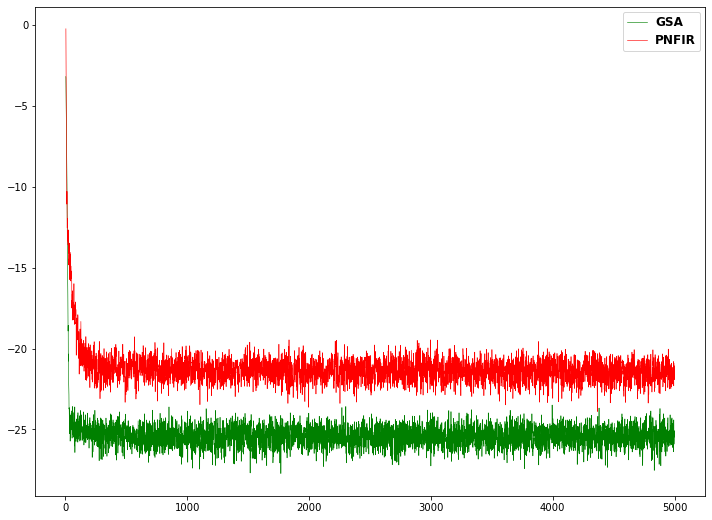

In [153]:
import matplotlib.pyplot as plt; plt.figure(figsize=(12, 9)); 
plt.plot(np.arange(N),10*np.log10(error2_sum_GSA),color='green',label="GSA",linewidth=0.6)
plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR),color='red',label="PNFIR",linewidth=0.6)
plt.legend(loc=0,numpoints=1);leg=plt.gca().get_legend();ltext=leg.get_texts()
plt.setp(ltext,fontsize=12,fontweight='bold');plt.show()

In [30]:
def input_set(sys_no,input_type,input_len,scale): 
    if(0==input_type): 
        input_raw=np.random.random(input_len)
    elif(1==input_type): 
        input_raw=2*np.random.random(input_len)-1
    elif(2==input_type):
        input_raw=np.random.standard_normal(size=input_len);
    elif(3==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=(-0.1)*white_noise[0]
        input_raw[1]=0.04*input_raw[0]-0.1*white_noise[1]-0.01*white_noise[0]
        input_raw[2]=0.04*input_raw[1]-0.034*input_raw[0]-0.1*white_noise[2]-0.01*white_noise[1]-0.137*white_noise[0]
        input_raw[3]=0.04*input_raw[2]-0.034*input_raw[1]+0.0396*input_raw[0]-0.1*white_noise[3]-0.01*white_noise[2] \
                     -0.137*white_noise[1]+0.0353*white_noise[0]
        for t in range(4,input_len):
            input_raw[t]=0.04*input_raw[t-1]-0.034*input_raw[t-2]+0.0396*input_raw[t-3]-0.07656*input_raw[t-4] \
            -0.1*white_noise[t]-0.01*white_noise[t-1]-0.137*white_noise[t-2]+0.0353*white_noise[t-3]+0.06984*white_noise[t-4]
    if(1==scale):
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(1-0))/(input_raw_max-input_raw_min)
    output_raw=(np.zeros(input_len))
    if(1==sys_no):
        for i in range(1,input_len): output_raw[i]=output_raw[i-1]/(1+output_raw[i-1]**2)+input_raw[i]**2
    elif(2==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=input_raw[i]+0.5*np.exp(-((input_raw[i-1]-1)**2)/0.67)-0.5*np.exp(-((input_raw[i-1]+1)**2)/0.67) 
    snr=30;info_power=((np.linalg.norm(output_raw))**2)/input_len;snr_lin = 10**(snr/10);noise_power = info_power/snr_lin;
    output_noise = output_raw + np.sqrt(noise_power)*np.random.standard_normal(input_len)
    return input_raw,output_raw,output_noise

def JPPSOV_model02(input_data,desire_data,M_num,p_num,train,sort):
    nonlin_input_len=p_num+1;
    nonlin_weight_len=int(1+(p_num+1)+(p_num+1)*(p_num+2)/2)
    weight_nonlin = 0.001*(np.random.standard_normal(M_num*nonlin_weight_len)).reshape(M_num,nonlin_weight_len)
    weight_linear = 0.001*(np.random.standard_normal(M_num))
    input_module=np.zeros(nonlin_input_len); input_post = np.ones(nonlin_weight_len)
    output_modul = np.zeros(M_num); output_filter = np.zeros(len(input_data))
    error=np.zeros_like(input_data)
    for j in range(M_num+p_num-2+1,len(input_data)):
        input_set=np.zeros_like(weight_nonlin);
        for jj in range(0,M_num):
        #for jj in range(M_num-1,-1,-1):
            if(jj==(M_num-1)) : 
                if(1==sort):
                    input_module[0]=output_modul[jj]
                else:
                    input_module[0]=input_data[j-jj-1]
            else : 
                input_module[0]=output_modul[jj+1]
            for jjj in range(1,p_num+1):
                input_module[jjj]=input_data[j-jj-(jjj-1)]         
            input_post[1:1+nonlin_input_len]=input_module[:]; SOVlen=0
            for k in range(0,nonlin_input_len):
                for kk in range(k,nonlin_input_len):
                    input_post[1+nonlin_input_len+SOVlen]=input_module[k]*input_module[kk]
                    SOVlen=SOVlen+1
            output_modul[jj]=np.dot(weight_nonlin[jj],input_post.T)
            input_set[jj,:]=input_post
        output_filter[j]=np.dot(weight_linear,output_modul.T)
        error[j] = desire_data[j] - output_filter[j]
        gama=train[0]
        for L in range(0,M_num):
            weight_nonlin[L,:] = weight_nonlin[L,:] + \
                                train[2]*error[j]*(weight_linear[L]*input_set[L])/(gama+np.linalg.norm(weight_linear[L]*input_set[L])**2)
        weight_linear = weight_linear+train[1]*error[j]*output_modul/(gama+np.linalg.norm(output_modul)**2)     
    return output_filter,error,weight_linear,weight_nonlin
N = 5000; M=5; p=1; apoch=100
train_para=np.array([ 1, 0.5, 0.06]) 
error2_sum_JPPSOV02=np.zeros(N);
for times in range(0,apoch):
    x_raw,d_raw,d_noise=input_set(2,1,N,0)  # Random Sequence
    output_filter,error_JPPSOV02,weight_lin,weght_non=JPPSOV_model02(x_raw,d_noise,M,p,train_para,0) #JPPSOV01
    error2_sum_JPPSOV02+=error_JPPSOV02**2
    if(0==times%50):
        print('apoch:',times,'JPPSOV01 ',10*np.log10(np.mean(error_JPPSOV02[-200:]**2)),'dB')
error2_sum_JPPSOV02/=apoch;
print('apoch:',apoch,'mean_MSE:','JPPSOV01',np.mean(error2_sum_JPPSOV02))

apoch: 0 JPPSOV01  -27.864063072913012 dB
apoch: 50 JPPSOV01  -28.72263765393469 dB
apoch: 100 mean_MSE: JPPSOV01 0.015850607108298918


C:\Users\Administrator\AppData\Local\Temp/ipykernel_17684/1434126903.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N),10*np.log10(error2_sum_JPPSOV02),color='green',label="JPPSOV",linewidth=0.6)
C:\Users\Administrator\AppData\Local\Temp/ipykernel_17684/1434126903.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR02),color='red',label="PNFIR",linewidth=0.6)


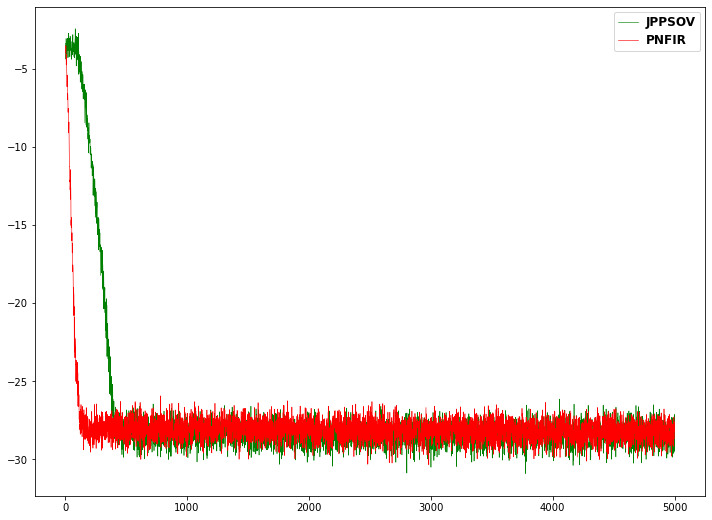

In [45]:
import matplotlib.pyplot as plt; plt.figure(figsize=(12, 9)); 
plt.plot(np.arange(N),10*np.log10(error2_sum_JPPSOV02),color='green',label="JPPSOV",linewidth=0.6)
plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR02),color='red',label="PNFIR",linewidth=0.6)
plt.legend(loc=0,numpoints=1);leg=plt.gca().get_legend();ltext=leg.get_texts()
plt.setp(ltext,fontsize=12,fontweight='bold');plt.show()

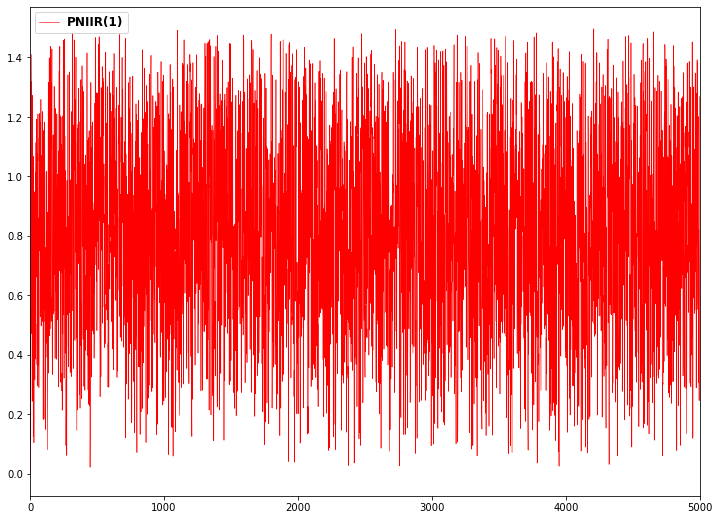

In [10]:
x_raw,d_raw,d_noise=input_set(2,1,N,0)    #  gaussian
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9)); 
plt.plot(np.arange(N), d_raw, color='red',label="PNIIR(1)", linewidth=0.6)
plt.xlim(0,N)
plt.legend(loc=0, numpoints=1);leg = plt.gca().get_legend();ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold');plt.show()